# Analyzing Training, Validation, and Testing Sets

Investigation of the dataset for new reflector short tank data

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Process, Pool
import boost_histogram as bh

In [5]:
# Add the path to the parent directory to augment search for module

if "../../.." not in sys.path:
    print("adding pardir")
    sys.path.append("../../..")

from WatChMaL_analysis.short_tank_EDA.old_reflector_short_tank_exploratory_data_analysis.exploratory_data_analysis_utils import *

adding pardir


# Load Data From H5

In [6]:
# Import test events from h5 file
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_emg_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

hdf5_hit_pmt    = data_file["hit_pmt"]
hdf5_hit_time   = data_file["hit_time"]
hdf5_hit_charge = data_file["hit_charge"]


hit_pmt    = np.memmap(data_path, mode="r", shape=hdf5_hit_pmt.shape,
                                    offset=hdf5_hit_pmt.id.get_offset(), dtype=hdf5_hit_pmt.dtype)

hit_time   = np.memmap(data_path, mode="r", shape=hdf5_hit_time.shape,
                                    offset=hdf5_hit_time.id.get_offset(), dtype=hdf5_hit_time.dtype)

hit_charge = np.memmap(data_path, mode="r", shape=hdf5_hit_charge.shape,
                                    offset=hdf5_hit_charge.id.get_offset(), dtype=hdf5_hit_charge.dtype)

angles     = np.array(data_file['angles'])
energies   = np.array(data_file['energies'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])
root_files = np.array(data_file['root_files'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


# Load Indices

In [7]:
idxs_path = '../../short_tank_EDA/new_reflector_short_tank_exploratory_data_analysis/short_dataset_data/IWCD_mPMT_Short_3M_OD_veto_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)

train_idxs = idxs['train_idxs']
val_idxs   = idxs['val_idxs']
test_idxs  = idxs['test_idxs']

# Split Datasets

In [8]:
train_angles    = angles[train_idxs]
train_energies  = energies[train_idxs]
train_positions = positions[train_idxs]
train_labels    = labels[train_idxs]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 'angles':train_angles, 'labels':train_labels}

print("Done train info")

val_angles     = angles[val_idxs]
val_energies   = energies[val_idxs]
val_positions  = positions[val_idxs]
val_labels     = labels[val_idxs]

val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 'angles':val_angles, 'labels':val_labels}

print("Done val info")

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]
test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 'angles':test_angles, 'labels':test_labels}

print("Done test info")

Done train info
Done val info
Done test info


In [9]:
# compute and save event radii
"""
train_radius    = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]
val_radius     = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]
test_radius    = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]

np.savez('./short_dataset_data/event_radii.npz', train_radii=train_radius, val_radii=val_radius, test_radii=test_radius)
"""

"\ntrain_radius    = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]\nval_radius     = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]\ntest_radius    = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]\n\nnp.savez('./short_dataset_data/event_radii.npz', train_radii=train_radius, val_radii=val_radius, test_radii=test_radius)\n"

In [10]:
radii_data = np.load('./short_dataset_data/event_radii.npz', allow_pickle=True)

train_info['radius'] = radii_data['train_radii']
val_info['radius']   = radii_data['val_radii']
test_info['radius']  = radii_data['test_radii']

FileNotFoundError: [Errno 2] No such file or directory: './short_dataset_data/event_radii.npz'

In [11]:
dataset_info = [train_info, val_info, test_info]

# Get indices associated with each dataset and particle type

In [12]:
train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
val_g_idxs   = np.where(dataset_info[1]['labels']==0)[0]
test_g_idxs  = np.where(dataset_info[2]['labels']==0)[0]

train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
val_e_idxs   = np.where(dataset_info[1]['labels']==1)[0]
test_e_idxs  = np.where(dataset_info[2]['labels']==1)[0]

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs   = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs  = np.where(dataset_info[2]['labels']==2)[0]

# Load detector geometry parameters

In [13]:
barrel_map_array_idxs = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
pmts_per_mpmt = 19

event_hits_index = np.append(data_file["event_hits_index"], hdf5_hit_pmt.shape[0]).astype(np.int64)

mpmt_positions_file = '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz'
mpmt_positions   = np.load(mpmt_positions_file)['mpmt_image_positions']

data_size = np.max(mpmt_positions, axis=0) + 1
n_channels = pmts_per_mpmt
data_size = np.insert(data_size, 0, n_channels)

# Hit Charges

In [14]:
def get_large_hist(pos, indices, bins, name):
    #TODO: Until tqdm in the docker image is updated, this print statement appears to be required
    print('')
    pmt_charge = []
    description = '{} Progress: '.format(name)
    
    hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1]))#, growth=True))
    for i in tqdm(indices, desc=description, position=pos):
        item = i
        start = event_hits_index[item]
        stop  = event_hits_index[item + 1]
        hit_data = hit_charge[start:stop]

        hist.fill(hit_data)

    return hist.to_numpy()

In [15]:
def get_large_hists(input_sets, bins, names):
    pool = Pool(len(input_sets))
    arg_list = [(idx, item, bins, name) for idx, (item, name) in enumerate(zip(input_sets, names))]
    result_hists, result_bins = zip(*pool.starmap(get_large_hist, arg_list))
    return result_hists, result_bins

In [16]:
# Define plotting bins
N = 100
plot_bins = np.linspace(0, 2000, N + 1)

In [17]:
test_large_plot_inputs = [train_g_idxs[0:1000], train_e_idxs[0:1000]]
test_large_plot_names = ['train_g', 'train_e']

test_hists, test_bins = get_large_hists(test_large_plot_inputs, plot_bins, test_large_plot_names)

../../../WatChMaL_analysis/short_tank_EDA/old_reflector_short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:282: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
../../../WatChMaL_analysis/short_tank_EDA/old_reflector_short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:282: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],


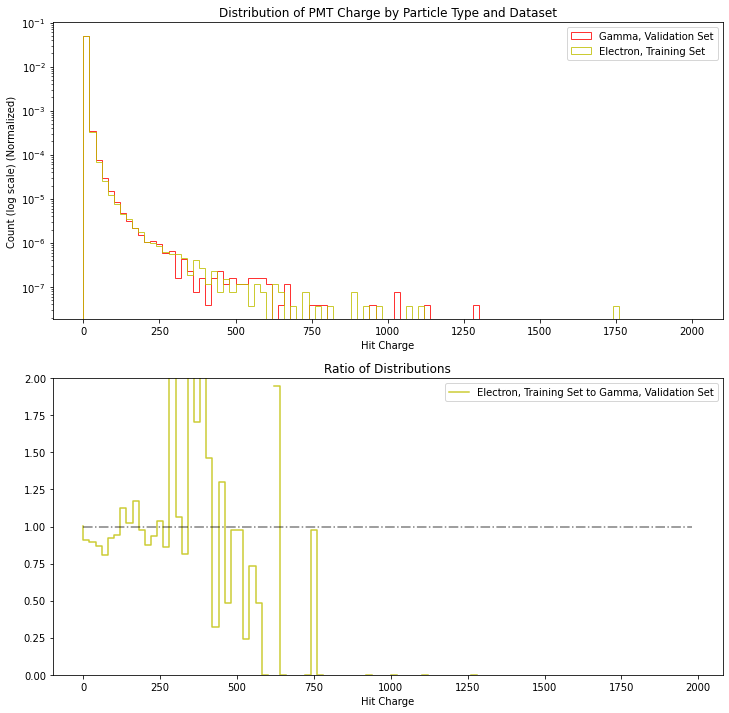

In [18]:
plot_computed_dists(test_hists, 
                    bins=test_bins,
                    numerator_dist_idxs   = [1],
                    denominator_dist_idxs = [0],
                    labels=['Gamma, Validation Set', 'Electron, Training Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Charge by Particle Type and Dataset', 
                    colors =  ['r','y'],
                    linestyle=['-','-'],
                    yscale='log',
                    xlabel='Hit Charge'
                   )

In [ ]:
# Get hist data for full dataset
large_plot_inputs = [train_g_idxs, val_g_idxs, test_g_idxs,
                     train_e_idxs, val_e_idxs, test_e_idxs,
                     train_m_idxs, val_m_idxs, test_m_idxs,]

large_plot_names = ['train_g', 'val_g', 'test_g',
                    'train_e', 'val_e', 'test_e',
                    'train_m', 'val_m', 'test_m']

outputs = get_large_hists(large_plot_inputs, plot_bins, large_plot_names)

In [ ]:
# Plot overall distribution
plot_computed_dists(outputs[0], 
                    bins=outputs[1],
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Charge by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'],
                    normalized=False,
                    yscale='log',
                    xlabel='Hit Charge'
                   )

# Hit times

In [ ]:
def get_large_times_hist(pos, indices, bins, name):
    #TODO: Until tqdm in the docker image is updated, this print statement appears to be required
    print('')
    pmt_charge = []
    description = '{} Progress: '.format(name)
    
    hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1]))#, growth=True))
    for i in tqdm(indices, desc=description, position=pos):
        item = i
        start = event_hits_index[item]
        stop  = event_hits_index[item + 1]
        hit_data = hit_time[start:stop]

        hist.fill(hit_data)

    return hist.to_numpy()

In [ ]:
def get_large_times_hists(input_sets, bins, names):
    pool = Pool(len(input_sets))
    arg_list = [(idx, item, bins, name) for idx, (item, name) in enumerate(zip(input_sets, names))]
    result_hists, result_bins = zip(*pool.starmap(get_large_times_hist, arg_list))
    return result_hists, result_bins

In [ ]:
time_plot_bins = np.linspace(500, 2000, 200)

In [ ]:
# Get hist data for full dataset
time_large_plot_inputs = [train_g_idxs, val_g_idxs, test_g_idxs,
                     train_e_idxs, val_e_idxs, test_e_idxs,
                     train_m_idxs, val_m_idxs, test_m_idxs,]

time_large_plot_names = ['train_g', 'val_g', 'test_g',
                    'train_e', 'val_e', 'test_e',
                    'train_m', 'val_m', 'test_m']

time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, time_plot_bins, time_large_plot_names)

In [ ]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    yscale='log',
                    xlabel='Hit Time (ns)'
                   )